In [1]:
import pickle
import os
import sys

dir2 = os.path.abspath("")
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir("../..")

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import shap
from sklearn.metrics import ndcg_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder


libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS: 
/home/user/conda/envs/recsys/lib/python3.9/site-packages/numba/core/config.py:154: RuntimeWarning: environ NUMBA_NUM_THREADS defined but failed to parse ''
  warnings.warn("environ %s defined but failed to parse '%s'" %

libgomp: Invalid value for environment variable OMP_NUM_THREADS
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
df = pd.read_csv(os.path.join("notebooks", "feature_importance", "data.csv"), index_col=False)

In [4]:
encoder = TargetEncoder()
df['Model_Encoded'] = encoder.fit_transform(df['Method'], df['Value'])

In [5]:
df['Rank'] = df.groupby('Dataset')['Value'].rank(ascending=False)

In [6]:
df[df['Dataset'] == 'brightkite'][['Dataset', 'Method', 'Value', 'Rank', 'Model_Encoded']]

,Dataset,Method,Value,Rank,Model_Encoded
0,brightkite,sasrec,0.015073,7.0,0.054517
1,brightkite,recbole_ItemKNN,0.092339,4.0,0.052196
2,brightkite,recbole_EASE,0.140293,1.0,0.059444
3,brightkite,recbole_MultiVAE,0.118833,3.0,0.053747
4,brightkite,implicit_bpr,0.054292,6.0,0.033160
5,brightkite,implicit_als,0.068651,5.0,0.035042
6,brightkite,lightfm,0.122537,2.0,0.054798


In [7]:
# Split by dataset_name to ensure entire groups are in train or test, not split between them
train_datasets, test_datasets = train_test_split(df['Dataset'].unique(), test_size=0.1, random_state=142)

train_df = df[df['Dataset'].isin(train_datasets)]
test_df = df[df['Dataset'].isin(test_datasets)]

In [8]:
X_train = train_df[train_df.columns.difference(['Dataset', 'Dataset_group', 'Method', 'Value', 'Rank'])]
y_train = train_df['Rank'].values
group_train = train_df.groupby('Dataset')['Dataset'].count().to_numpy()

X_test = test_df[test_df.columns.difference(['Dataset', 'Dataset_group', 'Method', 'Value', 'Rank'])]
y_test = test_df['Rank'].values
group_test = test_df.groupby('Dataset')['Dataset'].count().to_numpy()

train_data = lgb.Dataset(X_train, label=y_train, group=group_train, free_raw_data=False)
test_data = lgb.Dataset(X_test, label=y_test, group=group_test, reference=train_data, free_raw_data=False)

In [24]:
train_df.keys()

Index(['Dataset', 'Nu', 'Ni', 'Nr', 'SpaceSize', 'Shape', 'Density', 'Rpu',
       'Rpi', 'Ginii', 'Giniu', 'APB', 'StPB', 'SkPB', 'KuPB', 'LTavg',
       'LTstd', 'LTsk', 'LTku', 'FracInteractionsVal', 'FracInteractionsTest',
       'FracPassiveUsersVal', 'FracPassiveUsersTest', 'FracPassiveItemsVal',
       'FracPassiveItemsTest', 'Method', 'Value', 'Model_Encoded', 'Rank',
       'Predicted_Score', 'Predicted_Rank'],
      dtype='object')

In [26]:
train_df[['Dataset', 'Nu', 'Ni', 'Nr', 'SpaceSize', 'Shape','Value', 'Model_Encoded', 'Rank',]]

,Dataset,Nu,Ni,Nr,SpaceSize,Shape,Value,Model_Encoded,Rank
14,epinions,16390,19933,311252,326701870,0.822255,0.005477,0.054517,5.0
15,epinions,16390,19933,311252,326701870,0.822255,0.013625,0.052196,2.0
16,epinions,16390,19933,311252,326701870,0.822255,0.014488,0.059444,1.0
17,epinions,16390,19933,311252,326701870,0.822255,0.012025,0.053747,3.0
18,epinions,16390,19933,311252,326701870,0.822255,0.002129,0.033160,6.0
...,...,...,...,...,...,...,...,...,...
177,ratebeer,8994,24935,1315273,224265390,0.360698,0.065166,0.059444,2.0
178,ratebeer,8994,24935,1315273,224265390,0.360698,0.057596,0.053747,6.0
179,ratebeer,8994,24935,1315273,224265390,0.360698,0.058280,0.033160,5.0
180,ratebeer,8994,24935,1315273,224265390,0.360698,0.064426,0.035042,3.0


In [9]:
param = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at': [1, 2, 3, 5],
    'boosting_type': 'gbdt',
    'num_leaves': 41,
    'learning_rate': 0.001,
    'bagging_fraction': 0.8
}

num_round = 1000
bst = lgb.train(param, train_data, num_round, valid_sets=[test_data], early_stopping_rounds=10, verbose_eval=30)

[LightGBM] [Info] Total Bins 584
[LightGBM] [Info] Number of data: 161, number of used features: 25
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping

In [14]:
# Predict the score for test data
train_df['Predicted_Score'] = bst.predict(X_train, num_iteration=bst.best_iteration)

# Rank the predictions
train_df['Predicted_Rank']= train_df.groupby('Dataset')['Predicted_Score'].rank(ascending=False, method='first')



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
test_df.keys()

Index(['Dataset', 'Nu', 'Ni', 'Nr', 'SpaceSize', 'Shape', 'Density', 'Rpu',
       'Rpi', 'Ginii', 'Giniu', 'APB', 'StPB', 'SkPB', 'KuPB', 'LTavg',
       'LTstd', 'LTsk', 'LTku', 'FracInteractionsVal', 'FracInteractionsTest',
       'FracPassiveUsersVal', 'FracPassiveUsersTest', 'FracPassiveItemsVal',
       'FracPassiveItemsTest', 'Method', 'Value', 'Model_Encoded', 'Rank',
       'Predicted_Score', 'Predicted_Rank'],
      dtype='object')

In [15]:
train_df[['Rank', 'Predicted_Rank']]

,Rank,Predicted_Rank
14,5.0,5.0
15,2.0,2.0
16,1.0,6.0
17,3.0,3.0
18,6.0,1.0
...,...,...
177,2.0,6.0
178,6.0,4.0
179,5.0,1.0
180,3.0,5.0


In [17]:
import scipy.stats
# Calculate Mean Spearman Rank Correlation Coefficient:
spearman_corr_list = []
num_of_methods = train_df['Method'].nunique()
y_pred = pd.DataFrame(bst.predict(X_train, num_iteration=bst.best_iteration)).rank(ascending=False, method='first')
for i in range(len(y_pred) // num_of_methods):
    spearman_corr, _ = scipy.stats.spearmanr(train_df['Rank'][i*num_of_methods:(i+1)*num_of_methods], y_pred[i*num_of_methods:(i+1)*num_of_methods])
    spearman_corr_list.append(spearman_corr)
    
print("Mean Spearman Rank Correlation Coefficient:", np.mean(spearman_corr_list))

Mean Spearman Rank Correlation Coefficient: -0.4270186335403727


In [18]:
# Use SHAP to interpret the model
explainer = shap.Explainer(bst)
shap_values = explainer(X_train)

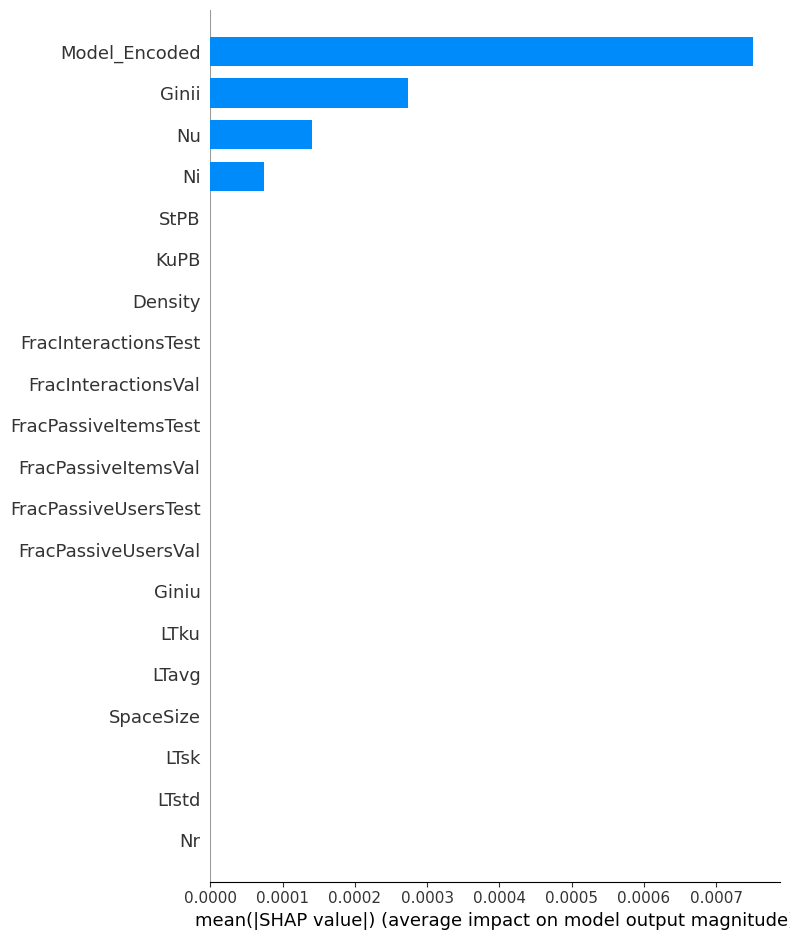

In [19]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


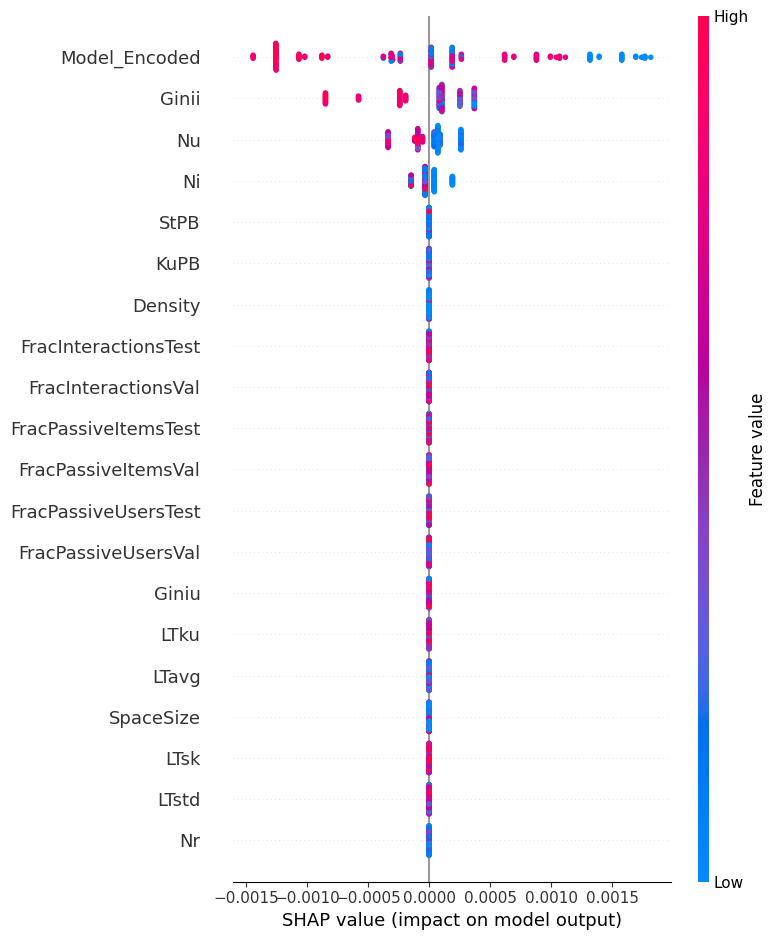

In [20]:
# Plot feature importance
shap.summary_plot(shap_values, X_train)

In [21]:
mean_shap_values = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.Series(mean_shap_values, index=X_test.columns).sort_values(ascending=False)
print(feature_importance)

Model_Encoded           0.000751
Ginii                   0.000273
Nu                      0.000140
Ni                      0.000074
StPB                    0.000000
KuPB                    0.000000
Density                 0.000000
FracInteractionsTest    0.000000
FracInteractionsVal     0.000000
FracPassiveItemsTest    0.000000
FracPassiveItemsVal     0.000000
FracPassiveUsersTest    0.000000
FracPassiveUsersVal     0.000000
Giniu                   0.000000
LTku                    0.000000
LTavg                   0.000000
SpaceSize               0.000000
LTsk                    0.000000
LTstd                   0.000000
Nr                      0.000000
Rpi                     0.000000
Rpu                     0.000000
Shape                   0.000000
SkPB                    0.000000
APB                     0.000000
dtype: float64


In [35]:
# Predict the score for test data
train_df['Predicted_Score'] = bst.predict(X_train, num_iteration=bst.best_iteration)

# Rank the predictions
train_df['Predicted_Rank'] = train_df.groupby('Dataset')['Predicted_Score'].rank(ascending=False, method='first')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [37]:
import scipy.stats
# Calculate Mean Spearman Rank Correlation Coefficient:
spearman_corr_list = []
num_of_methods = train_df['Method'].nunique()
y_pred = train_df['Predicted_Rank']
for i in range(len(y_pred) // num_of_methods):
    spearman_corr, _ = scipy.stats.spearmanr(train_df['Rank'][i*num_of_methods:(i+1)*num_of_methods], y_pred[i*num_of_methods:(i+1)*num_of_methods])
    spearman_corr_list.append(spearman_corr)
    
print("Mean Spearman Rank Correlation Coefficient:", np.mean(spearman_corr_list))


Mean Spearman Rank Correlation Coefficient: -0.4270186335403727
